In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import re
import unicodedata
import random

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SOS_TOKEN = 0
EOS_TOKEN = 1

class Lang():
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_TOKEN:'SOS', EOS_TOKEN: 'EOS'}
        self.n_words = 2
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1
            
        else:
            self.word2count[word] = 1

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
with open('data/eng-fra.txt') as f:
    lines = f.readlines()
    print(lines[:5])
    print(re.match('\n',lines[0]))


['Go.\tVa !\n', 'Run!\tCours\u202f!\n', 'Run!\tCourez\u202f!\n', 'Wow!\tÇa alors\u202f!\n', 'Fire!\tAu feu !\n']
None


In [47]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.GRU(hidden_size,hidden_size)

    def forward(self, input, hidden):
        embed = self.embedding(input).view(1,1,-1)
        # let's log it first to see the shape
        # need to unroll it with 
        out, hidden = self.rnn(embed, hidden)

        return (out, hidden)
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size,):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):
        
        embed = self.embedding(input).view(1,1,-1)
        
        out = F.relu(embed)

        # print('DECODER INTERNAL out 1: ', out)

        out, hidden = self.rnn(out, hidden)

        # print('DECODER INTERNAL out 2: ', out)

        out = self.out(out)

        # print('DECODER INTERNAL out 3: ', out)
        out = self.softmax(out)

        # print('DECODER INTERNAL out 4: ', out)

        return (out, hidden)
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['tu es plus grand que moi .', 'you re taller than i am .']
['tu es en danger .', 'you re in danger .']


In [26]:
# ideally we hot encode the dataset, so we don't do it at the time of the training loop
dataset = []

def sentenceToIndexes(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def sentenceToTensor(lang, sentence):
    ind = sentenceToIndexes(lang, sentence)
    ind.append(EOS_TOKEN)

    return torch.tensor(ind,dtype=torch.long).view(-1, 1)

for pair in pairs:
    dataset.append((
        sentenceToTensor(input_lang,pair[0]),
        sentenceToTensor(output_lang,pair[1]),
        pair[0],
        pair[1]
    
    ))



print(random.choice(dataset))
print(random.choice(dataset))
    

(tensor([[   6],
        [  11],
        [ 109],
        [ 417],
        [   6],
        [ 118],
        [   3],
        [3818],
        [   5],
        [   1]]), tensor([[   2],
        [   3],
        [  69],
        [1372],
        [   2],
        [ 618],
        [ 129],
        [   4],
        [   1]]), 'je suis desole si je vous ai embarrassees .', 'i m sorry if i embarrassed you .')
(tensor([[528],
        [349],
        [194],
        [529],
        [  5],
        [  1]]), tensor([[221],
        [ 78],
        [307],
        [  4],
        [  1]]), 'ce sont des garcons .', 'they re boys .')


# Training loop

In [13]:
input_lang.n_words


4345

In [14]:
output_lang.n_words

2803

In [108]:
criterion = nn.NLLLoss() 
hidden_size = 128 
learning_rate = 0.001 
encoder = Encoder(input_lang.n_words, hidden_size) 
decoder = Decoder(output_lang.n_words, hidden_size) 
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate) 
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate) 
sample_ouputs = []

all_losses = []
plot_every = 100
total_loss = 0.0


def trainSentence(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer): 
    encoder_optimizer.zero_grad() 
    decoder_optimizer.zero_grad() 
    
    hidden = encoder.initHidden() 
    loss = 0.0

    for word in input_tensor: 
        # print('enc word: ', word) 
        output, hidden = encoder(word, hidden) 
        # print('enc hidden: ', hidden) 
        # print('enc output: ', output) 
    
    # print('=============== DONE WITH ENCODING')
    output_tensors = [] # Teacher forcing by default, let's do couple of runs and then do non teacher forced 
    prev_word = torch.tensor([SOS_TOKEN]) 
    for word in target_tensor: 
        output, hidden = decoder(prev_word, hidden) 

        # print('dec hidden: ', hidden) 
        # print('dec output: ', output) 
        
        prev_word = word 
        # print('output: ', output[0].size()) 
        # print('word: ', word) # for each word compute loss ? or just do it in the end # compare word with output 
        loss += criterion(output[0], word)
        output_tensors.append(output[0]) 
        # print('max',torch.max(output[0]))

    # print('loss:', loss) 
    normalized_loss = loss.item() / (target_tensor.size(0) + 0.0)

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return (output_tensors, normalized_loss)



index = 0
for epoch in range(1):
    for i in range(0,len(dataset)):
        index += 1
        output, normalized_loss = trainSentence(dataset[i][0], dataset[i][1], encoder, decoder, encoder_optimizer, decoder_optimizer)
        total_loss += normalized_loss
        
        if index % plot_every == 0:
            all_losses.append(total_loss / (plot_every + 0.0))
            total_loss = 0
            print('index.. ', index, 'epoch...... ', epoch, ' loss...... ',all_losses[-1])


index..  100 epoch......  0  loss......  3.237690505981445
index..  200 epoch......  0  loss......  2.3552697114944454
index..  300 epoch......  0  loss......  2.589359596888225
index..  400 epoch......  0  loss......  1.9401830409367884
index..  500 epoch......  0  loss......  2.0948022130330397
index..  600 epoch......  0  loss......  2.2081492551167803
index..  700 epoch......  0  loss......  2.1729643402099605
index..  800 epoch......  0  loss......  1.8437348880767828
index..  900 epoch......  0  loss......  2.1114242048263545
index..  1000 epoch......  0  loss......  2.0603916620072864
index..  1100 epoch......  0  loss......  2.002584690343766
index..  1200 epoch......  0  loss......  1.816458715756735
index..  1300 epoch......  0  loss......  1.894667224679674
index..  1400 epoch......  0  loss......  2.4312988329387846
index..  1500 epoch......  0  loss......  2.3054464456694466
index..  1600 epoch......  0  loss......  1.7915739874839784
index..  1700 epoch......  0  loss....

KeyboardInterrupt: 

In [112]:
for b in output:
    a = torch.argmax(b)
    print(output_lang.index2word[a.item()])

i
m
letting
to
.
.
EOS


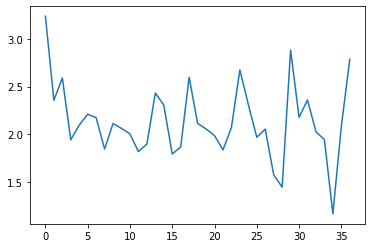

In [110]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)